In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import random
from collections import deque

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

In [50]:
# Fetch historical stock data
def fetch_data(symbol):
    data = yf.download(symbol, start='2010-01-01', end='2023-01-01')
    data = data['Close']
    return data

# Fetch data for a given stock
stock_data = fetch_data('AMZN') 

# Drop missing values
stock_data.dropna(inplace=True)

# Display the first few rows of the stock data
stock_data.head().to_frame()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2010-01-04,6.6950
2010-01-05,6.7345
2010-01-06,6.6125
2010-01-07,6.5000
2010-01-08,6.6760


In [51]:
class TradingEnvironment:
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        self.reset()

    def reset(self):
        self.current_step = self.window_size
        self.done = False
        self.total_reward = 0
        self.positions = []
        self.cash = 10000  # Starting cash
        self.stock_owned = 0  # Number of stocks owned
        return self._get_state()

    def _get_state(self):
        return self.data.iloc[self.current_step - self.window_size:self.current_step].values

    def step(self, action):
        if self.current_step >= len(self.data) - 1:
            self.done = True
            return self._get_state(), 0, self.done
        
        reward = 0
        current_price = self.data.iloc[self.current_step]
        if action == 0:  # Hold
            pass
        elif action == 1:  # Buy
            if self.cash >= current_price:
                self.stock_owned += 1
                self.cash -= current_price
                self.positions.append(current_price)
                reward = 1  # Small reward for buying
        elif action == 2:  # Sell
            if self.stock_owned > 0:
                self.stock_owned -= 1
                self.cash += current_price
                reward = 2  # Larger reward for selling

        self.current_step += 1

        if self.current_step < len(self.data):
            next_price = self.data.iloc[self.current_step]
            reward += self.stock_owned * (next_price - current_price)
        
        self.total_reward += reward
        return self._get_state(), reward, self.done

# Create an instance of the trading environment
env = TradingEnvironment(stock_data, window_size=10)
state = env.reset()
print("Initial State:", state)

Initial State: [6.69500017 6.73449993 6.61250019 6.5        6.67600012 6.51550007
 6.36749983 6.45550013 6.36749983 6.35699987]


In [52]:
class QLearningAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=1000)
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.8
        self.q_table = {}

    def _get_qs(self, state):
        return self.q_table.get(tuple(state), np.zeros(self.action_size))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        qs = self._get_qs(state)
        return np.argmax(qs)

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self._get_qs(next_state))
            current_qs = self._get_qs(state)
            current_qs[action] = (1 - self.learning_rate) * current_qs[action] + self.learning_rate * target
            self.q_table[tuple(state)] = current_qs

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize the Q-Learning agent
state_size = env.window_size
action_size = 3  # [Hold, Buy, Sell]
agent = QLearningAgent(state_size, action_size)

In [53]:
episodes = 100
batch_size = 32

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    while not env.done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            print(f"Episode: {e+1}/{episodes}, Total Reward: {total_reward}")
            break
    agent.replay(batch_size)

Episode: 1/100, Total Reward: 7584.714408874512
Episode: 2/100, Total Reward: 3761.5170288085938
Episode: 3/100, Total Reward: 2314.346980571747
Episode: 4/100, Total Reward: 4120.253640174866
Episode: 5/100, Total Reward: 6325.218987464905
Episode: 6/100, Total Reward: 4756.274448394775
Episode: 7/100, Total Reward: 9030.67986536026
Episode: 8/100, Total Reward: 2808.1841049194336
Episode: 9/100, Total Reward: 4702.87206363678
Episode: 10/100, Total Reward: 8701.444330215454
Episode: 11/100, Total Reward: 3857.763671398163
Episode: 12/100, Total Reward: 5264.093387126923
Episode: 13/100, Total Reward: 7885.470098495483
Episode: 14/100, Total Reward: 4505.77557849884
Episode: 15/100, Total Reward: 5000.145558357239
Episode: 16/100, Total Reward: 4168.737010955811
Episode: 17/100, Total Reward: 5564.16841840744
Episode: 18/100, Total Reward: 3377.212902069092
Episode: 19/100, Total Reward: 5511.348963737488
Episode: 20/100, Total Reward: 1954.574899673462
Episode: 21/100, Total Reward: 

Final Portfolio Value: 10189.890886306763


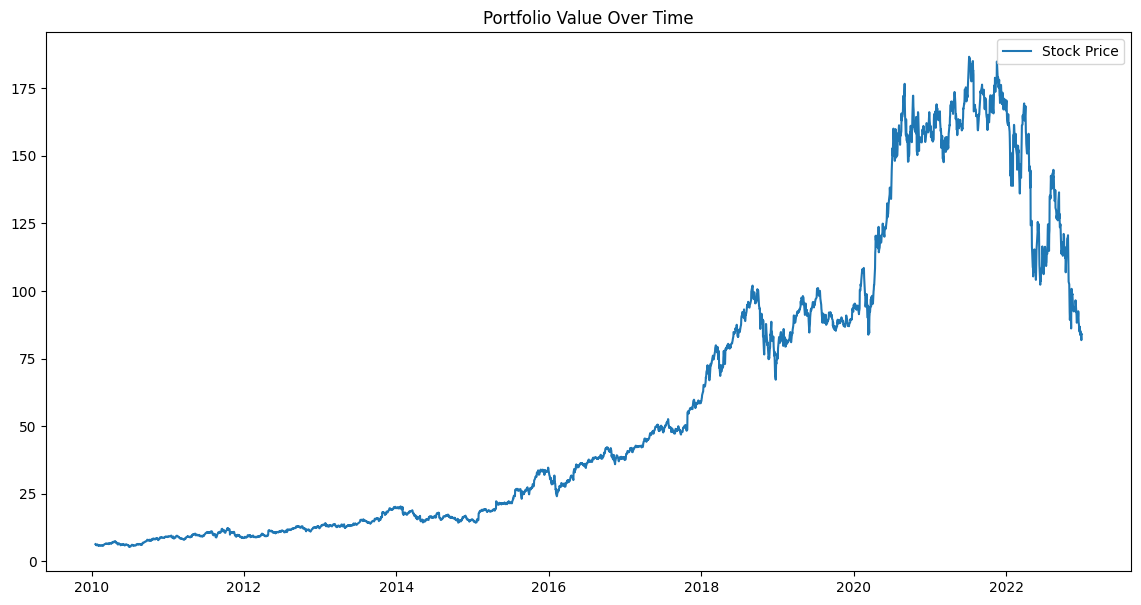

In [54]:
# Reset the environment and agent for backtesting
state = env.reset()
done = False
while not done:
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    state = next_state

# Calculate the total value of the portfolio
final_portfolio_value = env.cash + env.stock_owned * stock_data.iloc[-1]
print("Final Portfolio Value:", final_portfolio_value)

# Plot the portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[env.window_size:], stock_data.iloc[env.window_size:], label='Stock Price')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

## Reflection and Lessons Learned

Implemented a reinforcement learning trading strategy using the following tech stack:

### Tech Stack
- **Python**: The programming language used for implementation.
- **NumPy**: For numerical operations.
- **Pandas**: For data manipulation and analysis.
- **Matplotlib**: For data visualization.
- **yfinance**: To fetch historical stock data.

### Steps Taken
1. **Environment Setup**: Set up the environment by importing necessary libraries.
2. **Data Fetching**: Fetched historical daily close prices for a stock using the yfinance API.
3. **Trading Environment**: Defined a trading environment for the RL agent to interact with.
4. **Q-Learning Algorithm**: Implemented a Q-learning algorithm to train the agent.
5. **Training the Agent**: Trained the RL agent using historical data.
6. **Backtesting the Strategy**: Evaluated the performance of the trained agent.

### Key Learnings
- **Reinforcement Learning Basics**: Understanding the fundamentals of RL, including states, actions, and rewards.
- **Q-Learning Algorithm**: Implementing the Q-learning algorithm to train an agent to make trading decisions.
- **Backtesting**: Evaluating the effectiveness of the trading strategy using historical data.